In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

In [45]:
config = dict(
    n_epochs=500,
    batch_size=2**7,
    learning_rate=1e-5,
    weight_decay=0.01,
    target_loss=1e-10
)

In [46]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, source_file, train=True):
        data = pd.read_csv(source_file).dropna()
        # print(data.dtypes)
        x_data = data.drop(columns=['is_identical'])
        y_data = data[['is_identical']]

        self.x = torch.tensor(x_data.values, dtype=torch.float32)
        self.y = torch.tensor(y_data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [47]:
class TwoLayersNN(torch.nn.Module):
    
    def __init__(self, input_size, output_size):
        super(TwoLayersNN, self).__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, input_size).float(),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(input_size, input_size).float(),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(input_size, input_size).float(),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(input_size, input_size).float(),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(input_size, output_size).float(),
            torch.nn.Sigmoid()
        )

        self.layers.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.layers(x)

In [48]:
train_dataset = CustomDataset(source_file='data/train/2ao_2rs_axis-x.csv')

In [49]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True)

In [50]:
model = TwoLayersNN(input_size=train_dataset[0][0].shape[0], output_size=train_dataset[0][1].shape[0])
optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

criterion = torch.nn.BCELoss()

In [51]:
losses = []
lrs = []
finish_flag = False

progressbar = trange(config["n_epochs"])
for epoch in progressbar:
    progressbar.set_description(f'Epoch {epoch + 1}')
    
    for i, (x_train, y_train) in enumerate(train_dataloader):
        
        output = model(x_train)
        loss = criterion(output, y_train)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 10**6)
    
        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append(loss.item())

        if loss.item() < config["target_loss"]:
            finish_flag = True
            break

    if finish_flag:
        break
    
    progressbar.set_postfix({'loss': loss.item(), 'cma_loss': np.mean(losses[-config["batch_size"]:])})

  0%|          | 0/500 [00:00<?, ?it/s]

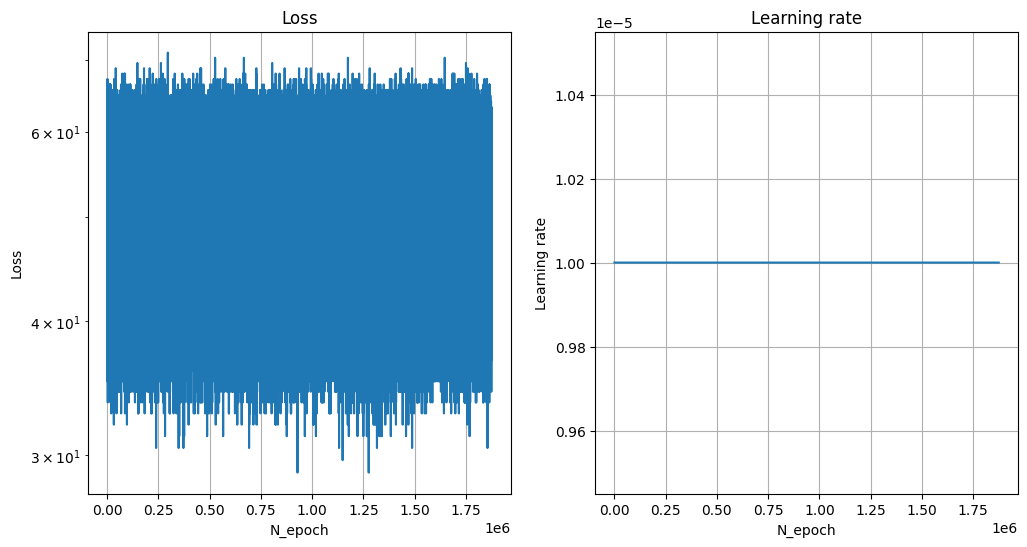

In [52]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# Loss plot
axis[0].set_title("Loss")
axis[0].set_xlabel("N_epoch")
axis[0].set_ylabel("Loss")
axis[0].semilogy()
axis[0].grid()
axis[0].plot(losses)

# Learning rate plot
axis[1].set_title("Learning rate")
axis[1].set_xlabel("N_epoch")
axis[1].set_ylabel("Learning rate")
axis[1].grid()
axis[1].plot(lrs)

In [53]:
# torch.save(model.state_dict(), "model-25022333.pt")

In [54]:
with torch.inference_mode():
    output = model(x_train)
    loss = criterion(output, y_train)
    print(loss)
    print(torch.hstack([output, y_train]))

tensor(52.6786)
tensor([[1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1.,

In [55]:
test_dataset = CustomDataset(source_file='data/test/2ao_2rs_axis-x.csv')

In [56]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config["batch_size"])

In [57]:
model.eval()
for x_test, y_test in test_loader:
    with torch.inference_mode():
        output = model(x_test)
        loss = criterion(output, y_test)
        print(loss)
        print(torch.hstack([output, y_test])[:20])

tensor(50.)
tensor([[1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.]])
tensor(50.)
tensor([[1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.]])
tensor(50.)
tensor([[1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        

In [58]:
assert 1 == 0

AssertionError: 

In [ ]:
velocities = [
    0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 2.5, 2.7, 3.0
]

for v in velocities:
    df_ = pd.read_csv(f'data/test/1ao_2rs_axis-x_track-{v}t.csv').dropna()
    x_test_, y_test_ = dataframe_to_tensors(df_, targets=['is_identical'])
    with torch.no_grad():
        print(f'Test loss on new system (velocity - {v}) : {criterion(model(x_test_), y_test_)}')
        print(model(x_test_))

In [ ]:
df_ = pd.read_csv(f'data/test/2ao_2rs_axis-x.csv').dropna()
x_test_, y_test_ = dataframe_to_tensors(df_, targets=['is_identical'])
with torch.no_grad():
    print(f'Test loss on new system : {criterion(model(x_test_), y_test_)}')
    print(model(x_test_)[:10])
    print(y_test_[:10])

In [ ]:
assert 1 == 0

In [ ]:
def log_crapped(x):
    return np.max([np.log(x), -100.0])

def bce_loss(x, y):
    return - (y * log_crapped(x) + (1.0 - y) * log_crapped(1.0 - x))

def mse_loss(x, y):
    return (x - y)**2

def mae_loss(x, y):
    return np.abs(x - y)

targets = [0.0, 1.0]
predictions = [0, 0.01, 0.5, 0.99, 1.0]

for xx in predictions:
    for yy in targets:
        print(f'prediction - {xx}, target - {yy}:')
        print(f'    bce_loss - {bce_loss(xx, yy)}')
        print(f'    mse_loss - {mse_loss(xx, yy)}')
        print(f'    mae_loss - {mae_loss(xx, yy)}')